### Importing Necessory Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../availability.csv')
df['time_stamp'] = pd.to_datetime(df['time_stamp']).dt.round('H')

In [3]:
result = df.groupby([df['time_stamp'], df['id']]).mean()
result = result.reset_index()
result['last_update'] = result['time_stamp']
result.set_index('last_update', inplace=True)

In [4]:
X = result[['time_stamp']]
y = result[['bike_stands', 'bikes']]

X['id'] = result['id']
X['time_stamp'] = pd.to_datetime(X['time_stamp'])
X['hour'] = X['time_stamp'].dt.hour
X['date_only'] = X['time_stamp'].dt.day
X['day_of_week'] = X['time_stamp'].dt.dayofweek
X['month_number'] = X['time_stamp'].dt.month
X = X.drop('time_stamp', axis=1)

In [5]:
X.head()

,id,hour,date_only,day_of_week,month_number
last_update,,,,,
2024-01-01,1,0,1,0,1
2024-01-01,2,0,1,0,1
2024-01-01,3,0,1,0,1
2024-01-01,4,0,1,0,1
2024-01-01,5,0,1,0,1


### Simple Statistics

In [6]:
data = df.copy()
data['time_stamp'] = pd.to_datetime(data['time_stamp'])
data.set_index('time_stamp', inplace=True)

In [7]:
last_week_data = data.loc[data.index >= (data.index.max() - pd.Timedelta(days=7))]
hourly_data_last_week = last_week_data.resample('H').mean()

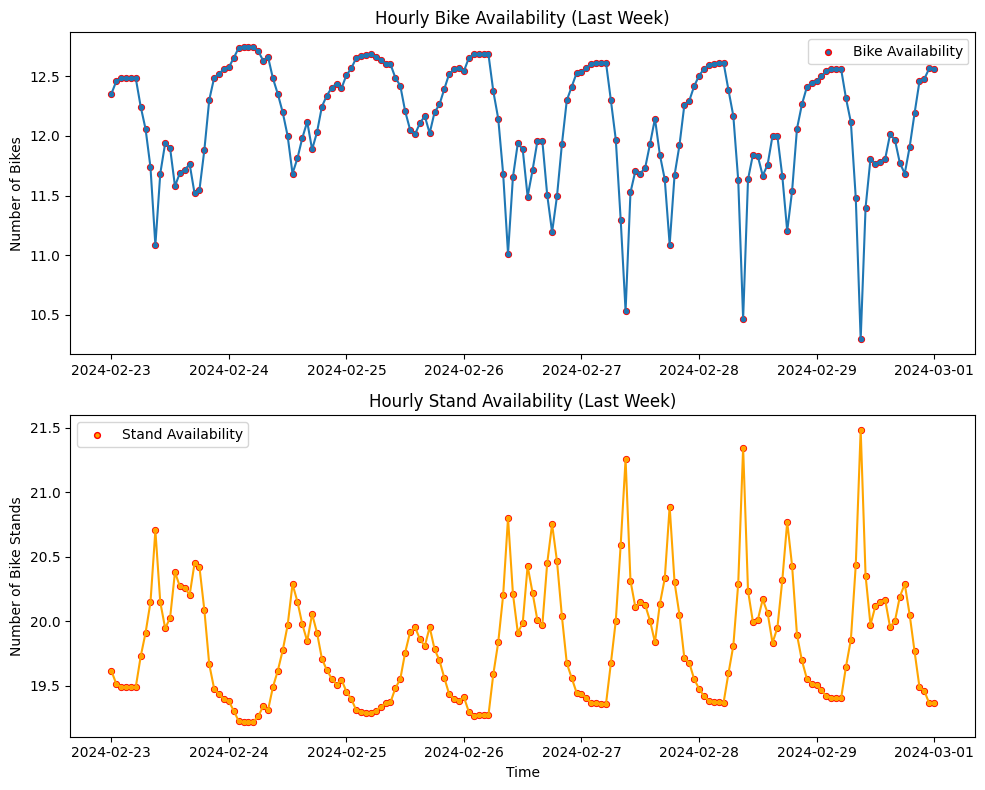

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
axes[0].plot(hourly_data_last_week.index, hourly_data_last_week['bikes'], marker='.')
axes[0].scatter(hourly_data_last_week.index, hourly_data_last_week['bikes'], marker='.', label='Bike Availability' ,edgecolors='red', s=70)
axes[0].set_title('Hourly Bike Availability (Last Week)')
axes[0].set_ylabel('Number of Bikes')
axes[0].legend()

axes[1].plot(hourly_data_last_week.index, hourly_data_last_week['bike_stands'], marker='.', color='orange')
axes[1].scatter(hourly_data_last_week.index, hourly_data_last_week['bike_stands'], label='Stand Availability', color='orange', marker='.' ,edgecolors='red', s=70)
axes[1].set_title('Hourly Stand Availability (Last Week)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Number of Bike Stands')
axes[1].legend()

plt.tight_layout()
plt.show()

#

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
def round_nearest(value):
    integer_part = int(value)
    fractional_part = value - integer_part
    if fractional_part >= 0.5:
        return integer_part + 1
    else:
        return integer_part

In [11]:
def model_performance_trees(regrssor, output, algorithm):
    regrssor.fit(X_train, y_train[output])
    y_pred = regrssor.predict(X_test)
    print(algorithm, "\t", output)
    mae = mean_absolute_error(y_test[output], y_pred)
    print("MAE : ", mae)
    mse = mean_squared_error(y_test[output], y_pred)
    print("MSE : ", mse)
    r2 = r2_score(y_test[output], y_pred)
    print("R-squared : ", r2)

    plt.scatter(y_test[output], y_pred, marker='.', color='blue' ,edgecolors='red', s=70)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set Predictions vs. Actual Values')
    plt.show()
    

In [12]:
def BayesSearch(model, param_space, output):
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    bayes_search.fit(X_train, y_train[output])
    best_params = bayes_search.best_params_
    print("Best parameters found:", best_params)

### Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
param_space = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 25, 20],
    'min_samples_leaf': [1, 2, 4, 5, 8, 9, 10],
    'bootstrap': [True, False]
}
# regressor_rf = RandomForestRegressor()
# BayesSearch(regressor_rf, param_space, 'bikes')

Best parameters found: OrderedDict({'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200})

In [15]:
# regressor_rf2 = RandomForestRegressor()
# BayesSearch(regressor_rf, param_space, 'bike_stands')

Best parameters found: OrderedDict({'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50})

Random Forest 	 bikes
MAE :  1.3393628167641325
MSE :  5.189055418494152
R-squared :  0.946234959945377


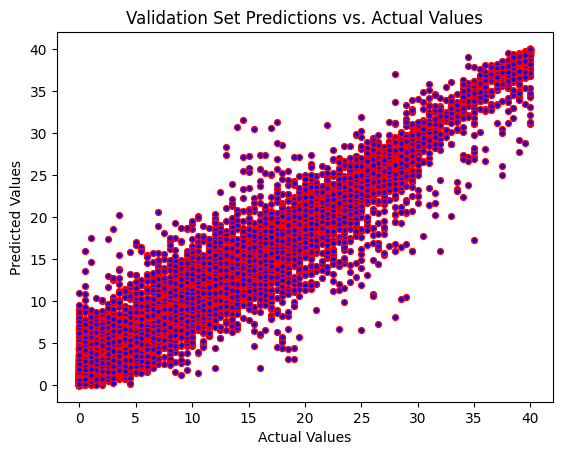

In [16]:
regressor_rf = RandomForestRegressor()
model_performance_trees(regressor_rf, 'bikes', 'Random Forest')

Random Forest 	 bike_stands
MAE :  1.3512375121832358
MSE :  5.271868830713937
R-squared :  0.9579287734331106


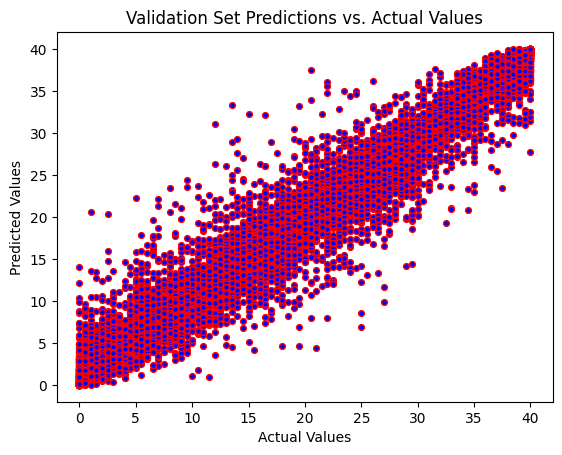

In [17]:
regressor_rf2 = RandomForestRegressor()
model_performance_trees(regressor_rf2, 'bike_stands', 'Random Forest')

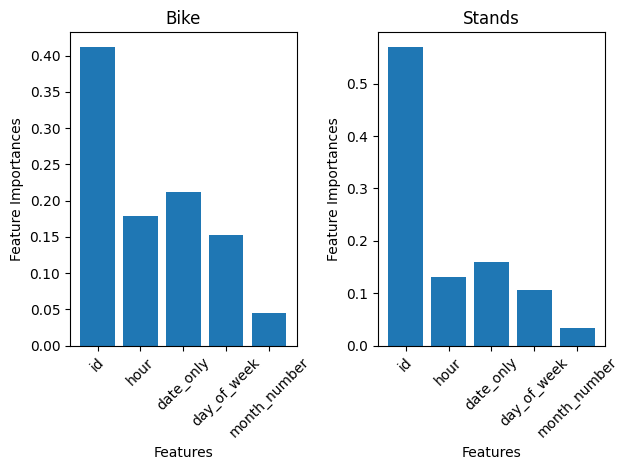

In [18]:
feature_importances_rf2 = regressor_rf2.feature_importances_
feature_importances_rf1 = regressor_rf.feature_importances_
features = X_train.columns

import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.bar(features, feature_importances_rf1)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Bike')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(features, feature_importances_rf2)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Stands')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [19]:
bikes = np.vectorize(round_nearest)(regressor_rf.predict(X_test))
stands = np.vectorize(round_nearest)(regressor_rf2.predict(X_test))
for i in range(10):
    print(f'Predicted: Bikes={np.round(bikes)[i]}, Bike Stands={np.round(stands)[i]} | Actual: Bikes={y_test['bikes'].values[i]}, Bike Stands={y_test['bike_stands'].values[i]}')

Predicted: Bikes=8, Bike Stands=22 | Actual: Bikes=11.5, Bike Stands=18.5
Predicted: Bikes=28, Bike Stands=2 | Actual: Bikes=28.0, Bike Stands=2.0
Predicted: Bikes=24, Bike Stands=16 | Actual: Bikes=25.5, Bike Stands=14.5
Predicted: Bikes=2, Bike Stands=39 | Actual: Bikes=3.5, Bike Stands=36.5
Predicted: Bikes=13, Bike Stands=28 | Actual: Bikes=12.5, Bike Stands=27.5
Predicted: Bikes=16, Bike Stands=22 | Actual: Bikes=17.0, Bike Stands=23.0
Predicted: Bikes=3, Bike Stands=36 | Actual: Bikes=1.5, Bike Stands=38.5
Predicted: Bikes=18, Bike Stands=4 | Actual: Bikes=19.0, Bike Stands=3.0
Predicted: Bikes=13, Bike Stands=24 | Actual: Bikes=24.0, Bike Stands=16.0
Predicted: Bikes=6, Bike Stands=24 | Actual: Bikes=3.5, Bike Stands=26.0


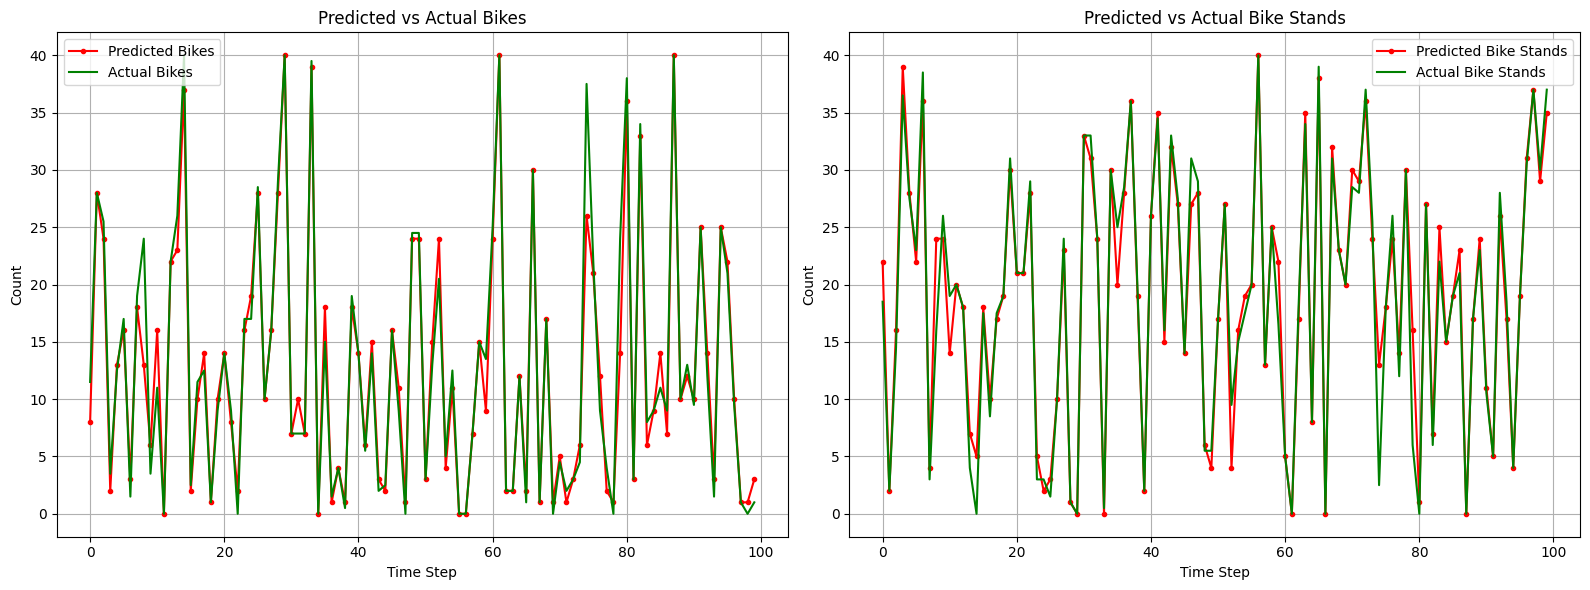

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(np.round(bikes)[:100], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_test['bikes'].values[:100], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.round(stands)[:100], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_test['bike_stands'].values[:100], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### XGBoost

In [21]:
from xgboost import XGBRegressor

In [22]:
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'max_depth': (3, 10),
    'n_estimators': (100, 500),
    'min_child_weight': (1, 10),
    'gamma': (0.0, 1.0, 'uniform'),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform')
}

# regressor_xgb = XGBRegressor()
# BayesSearch(regressor_xgb, param_space, 'bikes')

Best parameters found: OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.26368786949017864, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 1.0})

In [23]:
# regressor_xgb2 = XGBRegressor()
# BayesSearch(regressor_xgb2, param_space, 'bikes')

Best parameters found: OrderedDict({'colsample_bytree': 0.8644847671338562, 'gamma': 0.0, 'learning_rate': 0.333693540393556, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.9895759221145233})

XG Boost 	 bikes
MAE :  1.4138421095070897
MSE :  4.93919554952956
R-squared :  0.9488238176043347


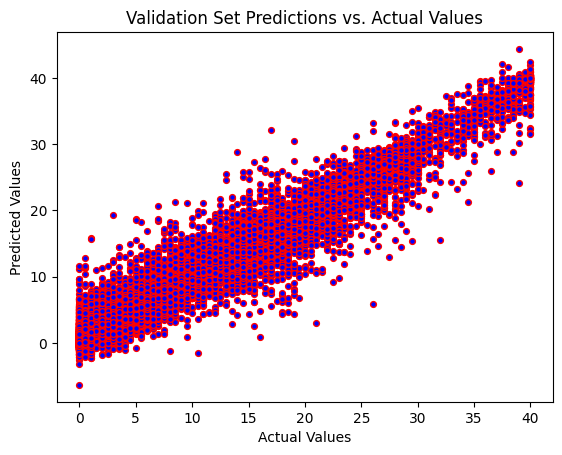

In [24]:
regressor_xgb = XGBRegressor(colsample_bytree=1.0, gamma=0.0, learning_rate=0.26368786949017864, max_depth=10, min_child_weight=1, n_estimators=500, subsample=1.0)
model_performance_trees(regressor_xgb, 'bikes', 'XG Boost')

XG Boost 	 bike_stands
MAE :  1.74917386841129
MSE :  6.543728861833661
R-squared :  0.9477789170446385


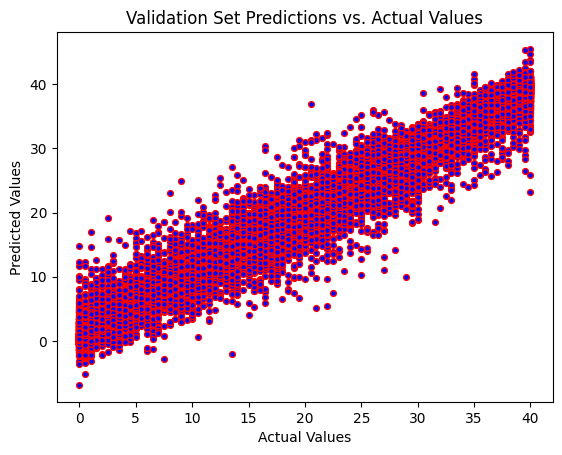

In [25]:
regressor_xgb2 = XGBRegressor(colsample_bytree=0.8644847671338562, gamma=0.0, learning_rate=0.333693540393556, max_depth=10, min_child_weight=1, n_estimators=500, subsample=0.9895759221145233)
model_performance_trees(regressor_xgb2, 'bike_stands', 'XG Boost')

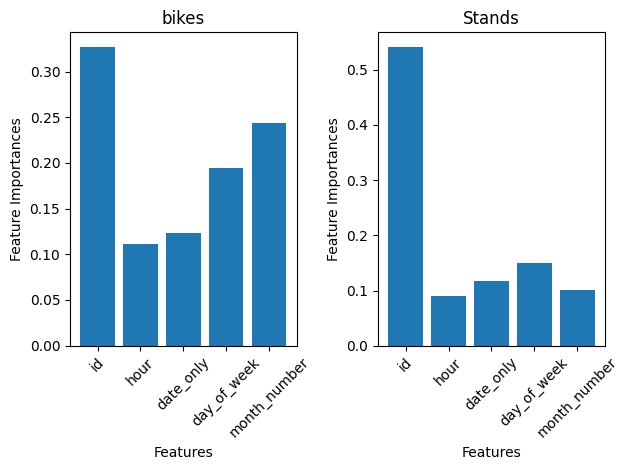

In [26]:
feature_importances_xgb2 = regressor_xgb2.feature_importances_
feature_importances_xgb1 = regressor_xgb.feature_importances_
features = X_train.columns

plt.subplot(1, 2, 1)
plt.bar(features, feature_importances_xgb1)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('bikes')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(features, feature_importances_xgb2)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Stands')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [27]:
bikes = np.vectorize(round_nearest)(regressor_xgb.predict(X_test))
stands = np.vectorize(round_nearest)(regressor_xgb2.predict(X_test))
for i in range(10):
    print(f'Predicted: Bikes={np.round(bikes)[i]}, Bike Stands={np.round(stands)[i]} | Actual: Bikes={y_test['bikes'].values[i]}, Bike Stands={y_test['bike_stands'].values[i]}')

Predicted: Bikes=10, Bike Stands=20 | Actual: Bikes=11.5, Bike Stands=18.5
Predicted: Bikes=28, Bike Stands=3 | Actual: Bikes=28.0, Bike Stands=2.0
Predicted: Bikes=26, Bike Stands=14 | Actual: Bikes=25.5, Bike Stands=14.5
Predicted: Bikes=2, Bike Stands=35 | Actual: Bikes=3.5, Bike Stands=36.5
Predicted: Bikes=12, Bike Stands=29 | Actual: Bikes=12.5, Bike Stands=27.5
Predicted: Bikes=17, Bike Stands=23 | Actual: Bikes=17.0, Bike Stands=23.0
Predicted: Bikes=3, Bike Stands=36 | Actual: Bikes=1.5, Bike Stands=38.5
Predicted: Bikes=17, Bike Stands=5 | Actual: Bikes=19.0, Bike Stands=3.0
Predicted: Bikes=13, Bike Stands=21 | Actual: Bikes=24.0, Bike Stands=16.0
Predicted: Bikes=6, Bike Stands=21 | Actual: Bikes=3.5, Bike Stands=26.0


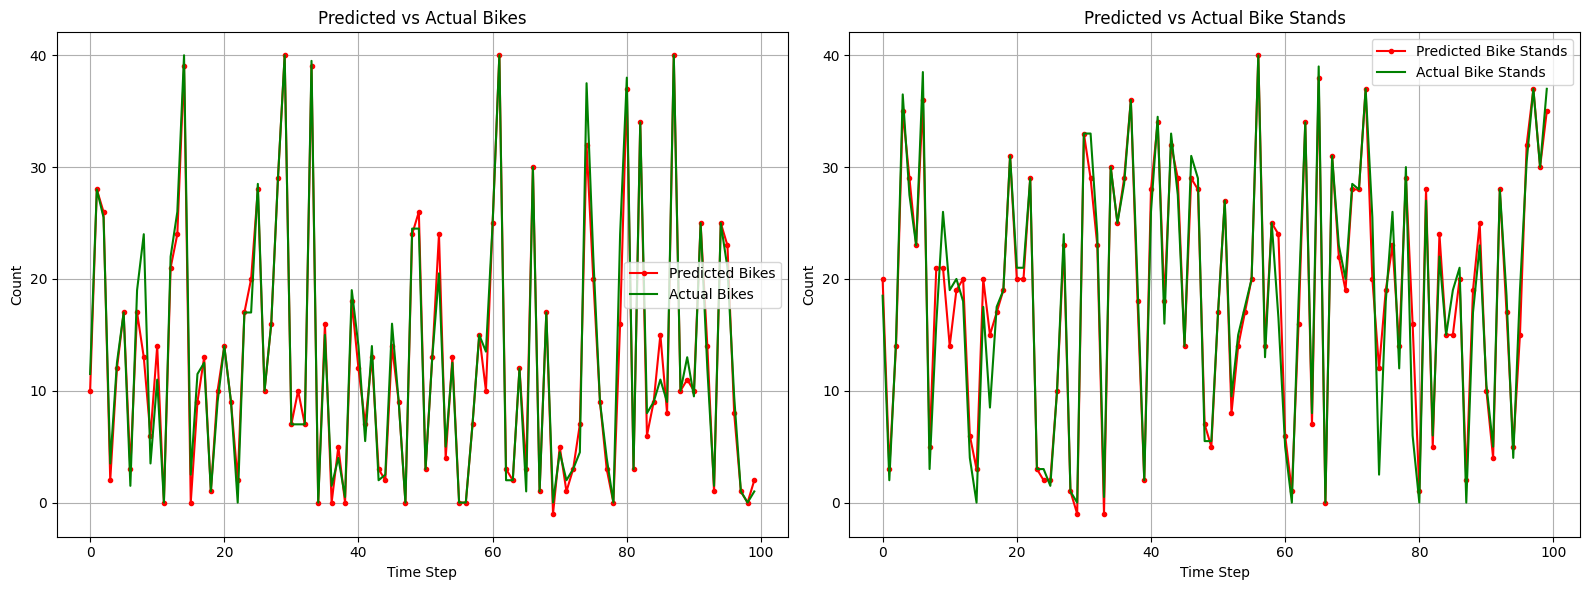

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(np.round(bikes)[:100], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_test['bikes'].values[:100], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.round(stands)[:100], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_test['bike_stands'].values[:100], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

##

In [29]:
def model_performance_non_tree(regrssor, output, algorithm, scalar, y_train_processed, X_train_processed, preprocessor):
    regrssor.fit(X_train_processed, y_train_processed)
    y_pred = regrssor.predict(preprocessor.transform(X_test))
    
    print(algorithm, "\t", output)
    mae = mean_absolute_error(y_test[output], scalar.inverse_transform(y_pred))
    print("MAE : ", mae)
    mse = mean_squared_error(y_test[output], scalar.inverse_transform(y_pred))
    print("MSE : ", mse)
    r2 = r2_score(y_test[output], scalar.inverse_transform(y_pred))
    print("R-squared : ", r2)

    plt.scatter(y_test[output], scalar.inverse_transform(y_pred), marker='.', color='blue' ,edgecolors='red', s=70)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set Predictions vs. Actual Values')
    plt.show()

In [30]:
def BayesSearch_non_tree(model, param_space, output, y_train_processed, X_train_processed):
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    bayes_search.fit(X_train_processed, y_train_processed)
    best_params = bayes_search.best_params_
    print("Best parameters found:", best_params)

### KNN

In [31]:
from sklearn.neighbors import KNeighborsRegressor

In [32]:
numeric_features = ['hour', 'date_only', 'day_of_week', 'month_number']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['id']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)

scalar1 = StandardScaler()
y_train_processed1 = scalar1.fit_transform(y_train['bikes'].values.reshape(-1, 1))
scalar2 = StandardScaler()
y_train_processed2 = scalar2.fit_transform(y_train['bike_stands'].values.reshape(-1, 1))

In [33]:
param_space = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'p': [1, 2] 
}

# regressor_knn = KNeighborsRegressor()
# BayesSearch_non_tree(regressor_knn, param_space, 'bikes', y_train_processed1, X_train_processed)

Best parameters found: OrderedDict({'algorithm': 'brute', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'})

In [34]:
# regressor_knn2 = KNeighborsRegressor()
# BayesSearch_non_tree(regressor_knn2, param_space, 'bikes', y_train_processed2, X_train_processed)

Best parameters found: OrderedDict({'algorithm': 'brute', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'})

KNN 	 bikes
MAE :  1.0770707865812352
MSE :  4.194975340289249
R-squared :  0.9565348605846535


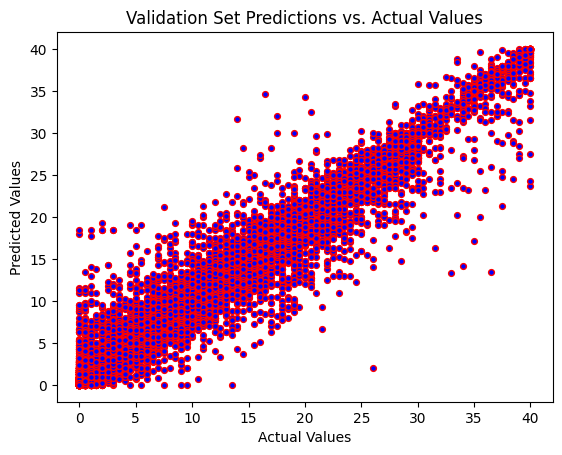

In [35]:
regressor_knn = KNeighborsRegressor(algorithm='brute', n_neighbors=2, p=1, weights='distance')
model_performance_non_tree(regressor_knn, 'bikes', 'KNN', scalar1, y_train_processed1, X_train_processed, preprocessor)

KNN 	 bike_stands
MAE :  1.0773560773544646
MSE :  4.186066475969885
R-squared :  0.9665938290974627


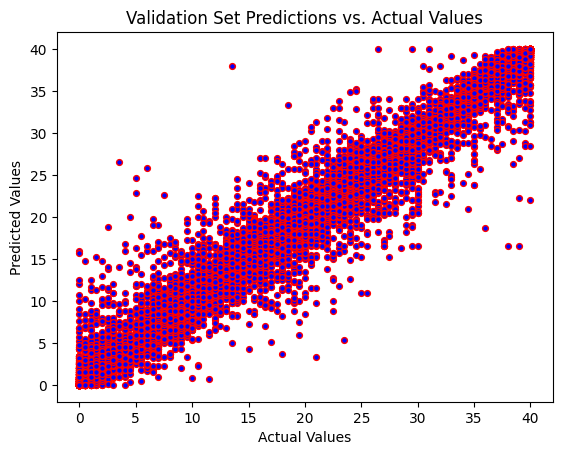

In [36]:
regressor_knn2 = KNeighborsRegressor(algorithm='brute', n_neighbors=2, p=1, weights='distance')
model_performance_non_tree(regressor_knn2, 'bike_stands', 'KNN', scalar2, y_train_processed2, X_train_processed, preprocessor)

In [37]:
bikes = np.vectorize(round_nearest)(scalar1.inverse_transform(regressor_knn.predict(preprocessor.transform(X_test))))
stands = np.vectorize(round_nearest)(scalar2.inverse_transform(regressor_knn2.predict(preprocessor.transform(X_test))))
for i in range(10):
    print(f'Predicted: Bikes={np.round(bikes)[i]}, Bike Stands={np.round(stands)[i]} | Actual: Bikes={y_test['bikes'].values[i]}, Bike Stands={y_test['bike_stands'].values[i]}')

Predicted: Bikes=[11], Bike Stands=[19] | Actual: Bikes=11.5, Bike Stands=18.5
Predicted: Bikes=[28], Bike Stands=[2] | Actual: Bikes=28.0, Bike Stands=2.0
Predicted: Bikes=[25], Bike Stands=[15] | Actual: Bikes=25.5, Bike Stands=14.5
Predicted: Bikes=[2], Bike Stands=[39] | Actual: Bikes=3.5, Bike Stands=36.5
Predicted: Bikes=[14], Bike Stands=[26] | Actual: Bikes=12.5, Bike Stands=27.5
Predicted: Bikes=[17], Bike Stands=[23] | Actual: Bikes=17.0, Bike Stands=23.0
Predicted: Bikes=[3], Bike Stands=[37] | Actual: Bikes=1.5, Bike Stands=38.5
Predicted: Bikes=[15], Bike Stands=[7] | Actual: Bikes=19.0, Bike Stands=3.0
Predicted: Bikes=[15], Bike Stands=[25] | Actual: Bikes=24.0, Bike Stands=16.0
Predicted: Bikes=[4], Bike Stands=[26] | Actual: Bikes=3.5, Bike Stands=26.0


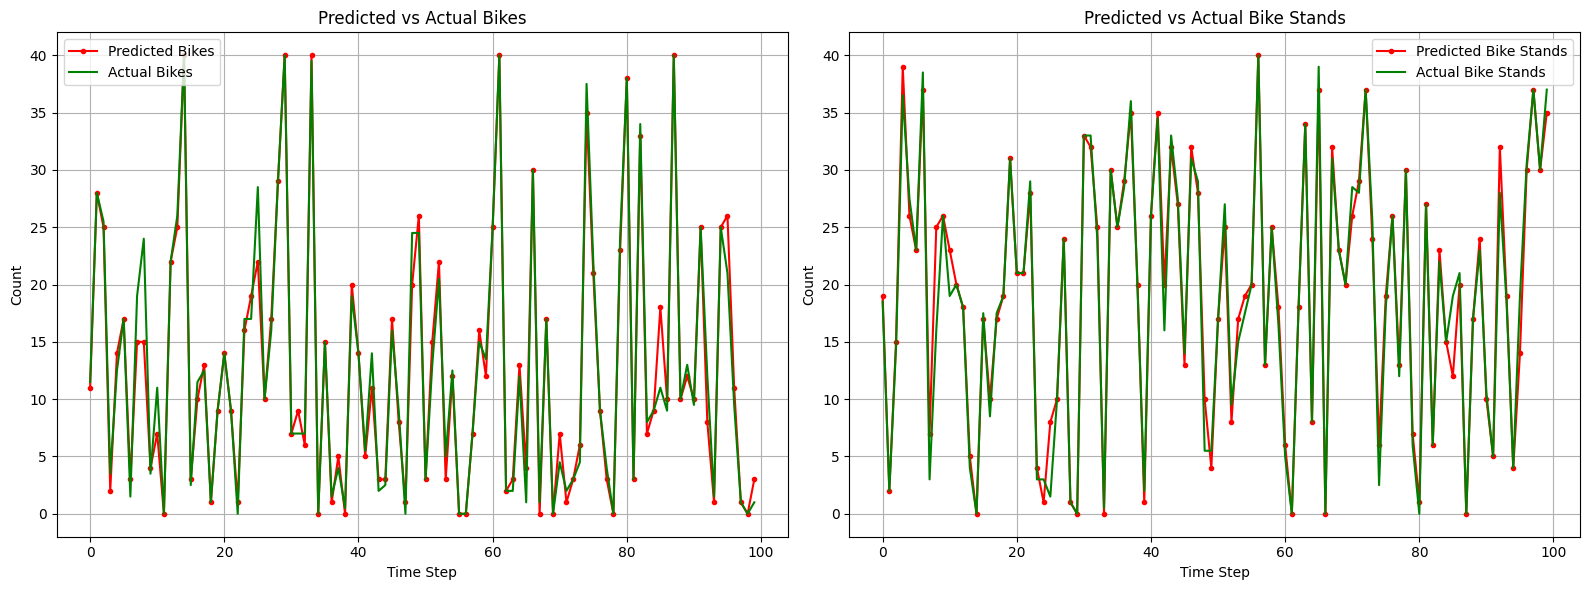

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(np.round(bikes)[:100], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_test['bikes'].values[:100], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.round(stands)[:100], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_test['bike_stands'].values[:100], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### ANN

In [39]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [40]:
numeric_features = ['hour', 'date_only', 'day_of_week', 'month_number']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['id']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor_ann = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_processed = preprocessor_ann.fit_transform(X_train)
scalar = StandardScaler()
y_train_processed = scalar.fit_transform(y_train.values)

In [41]:
input_shape = X_train_processed.shape[1:]

In [42]:
ann_model = Sequential([
    Dense(256, activation='relu', input_shape=input_shape),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(2)
])
ann_model.compile(optimizer='adam', loss='mse')

In [43]:
ann_model.fit(X_train_processed.toarray(), y_train_processed, epochs=10, batch_size=8)

Epoch 1/10


18468/18468 ━━━━━━━━━━━━━━━━━━━━ 12s 601us/step - loss: 0.4741
Epoch 2/10
18468/18468 ━━━━━━━━━━━━━━━━━━━━ 10s 554us/step - loss: 0.2505
Epoch 3/10
18468/18468 ━━━━━━━━━━━━━━━━━━━━ 10s 541us/step - loss: 0.1919
Epoch 4/10
18468/18468 ━━━━━━━━━━━━━━━━━━━━ 10s 540us/step - loss: 0.1602
Epoch 5/10
18468/18468 ━━━━━━━━━━━━━━━━━━━━ 10s 536us/step - loss: 0.1383
Epoch 6/10
18468/18468 ━━━━━━━━━━━━━━━━━━━━ 10s 534us/step - loss: 0.1220
Epoch 7/10
18468/18468 ━━━━━━━━━━━━━━━━━━━━ 10s 530us/step - loss: 0.1122
Epoch 8/10
18468/18468 ━━━━━━━━━━━━━━━━━━━━ 10s 547us/step - loss: 0.1041
Epoch 9/10
18468/18468 ━━━━━━━━━━━━━━━━━━━━ 10s 542us/step - loss: 0.0968
Epoch 10/10
18468/18468 ━━━━━━━━━━━━━━━━━━━━ 11s 596us/step - loss: 0.0937


In [44]:
X_test_processed = preprocessor_ann.transform(X_test)
y_pred = ann_model.predict(X_test_processed.toarray())

513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


In [45]:
predictions_inv = scalar.inverse_transform(y_pred)
y_test_inv = y_test.values

predictions_inv= np.vectorize(round_nearest)(predictions_inv)
y_test_inv = np.vectorize(round_nearest)(y_test_inv)

for i in range(10):
    print(f'Predicted: Bikes={predictions_inv[i][0]}, Bike Stands={predictions_inv[i][1]} | Actual: Bikes={y_test_inv[i][0]}, Bike Stands={y_test_inv[i][1]}')

Predicted: Bikes=20, Bike Stands=10 | Actual: Bikes=19, Bike Stands=12
Predicted: Bikes=3, Bike Stands=27 | Actual: Bikes=2, Bike Stands=28
Predicted: Bikes=18, Bike Stands=22 | Actual: Bikes=15, Bike Stands=26
Predicted: Bikes=34, Bike Stands=7 | Actual: Bikes=37, Bike Stands=4
Predicted: Bikes=28, Bike Stands=12 | Actual: Bikes=28, Bike Stands=13
Predicted: Bikes=27, Bike Stands=13 | Actual: Bikes=23, Bike Stands=17
Predicted: Bikes=37, Bike Stands=3 | Actual: Bikes=39, Bike Stands=2
Predicted: Bikes=8, Bike Stands=15 | Actual: Bikes=3, Bike Stands=19
Predicted: Bikes=21, Bike Stands=19 | Actual: Bikes=16, Bike Stands=24
Predicted: Bikes=19, Bike Stands=11 | Actual: Bikes=26, Bike Stands=4


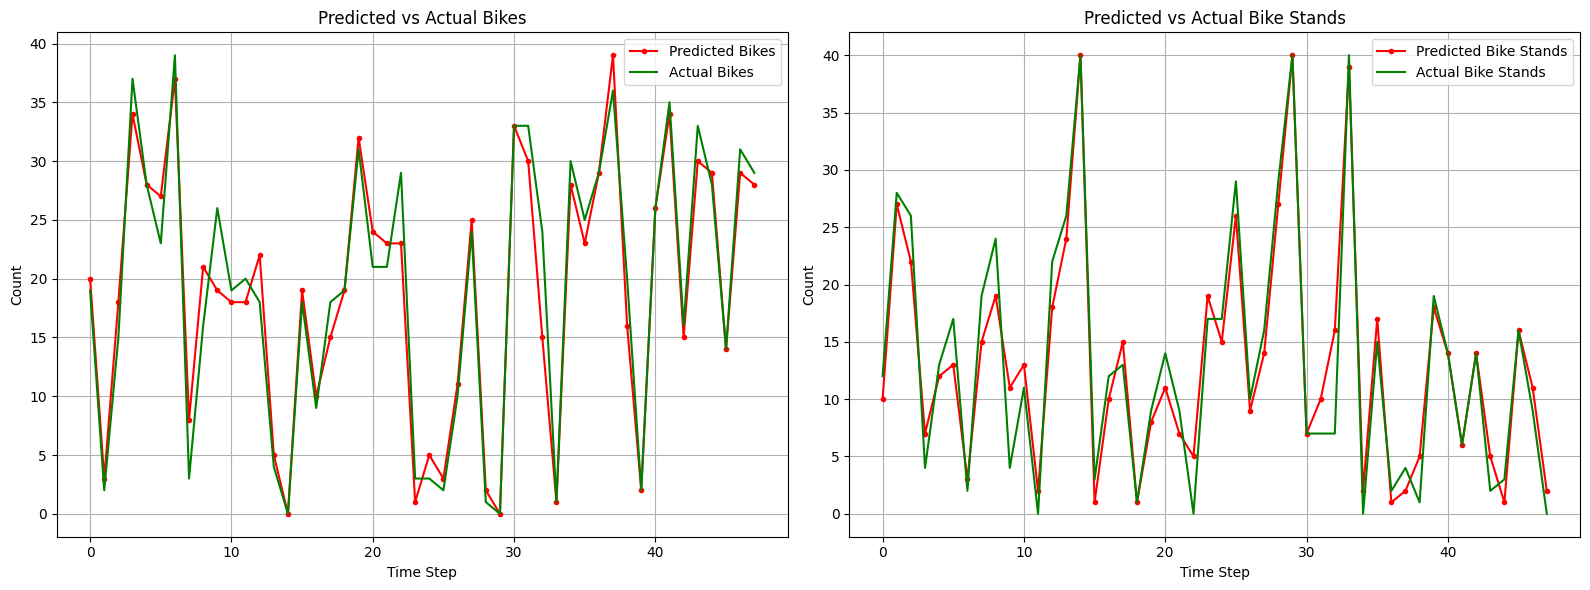

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(predictions_inv[:48, 0], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_test_inv[:48, 0], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(predictions_inv[:48, 1], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_test_inv[:48, 1], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [47]:
mae = mean_absolute_error(y_test, predictions_inv)
print("MAE : ", mae)
mse = mean_squared_error(y_test, predictions_inv)
print("MSE : ", mse)
r2 = r2_score(y_test, predictions_inv)
print("R-squared : ", r2)

MAE :  2.4537950779727096
MSE :  11.441764132553606
R-squared :  0.8951416726380846


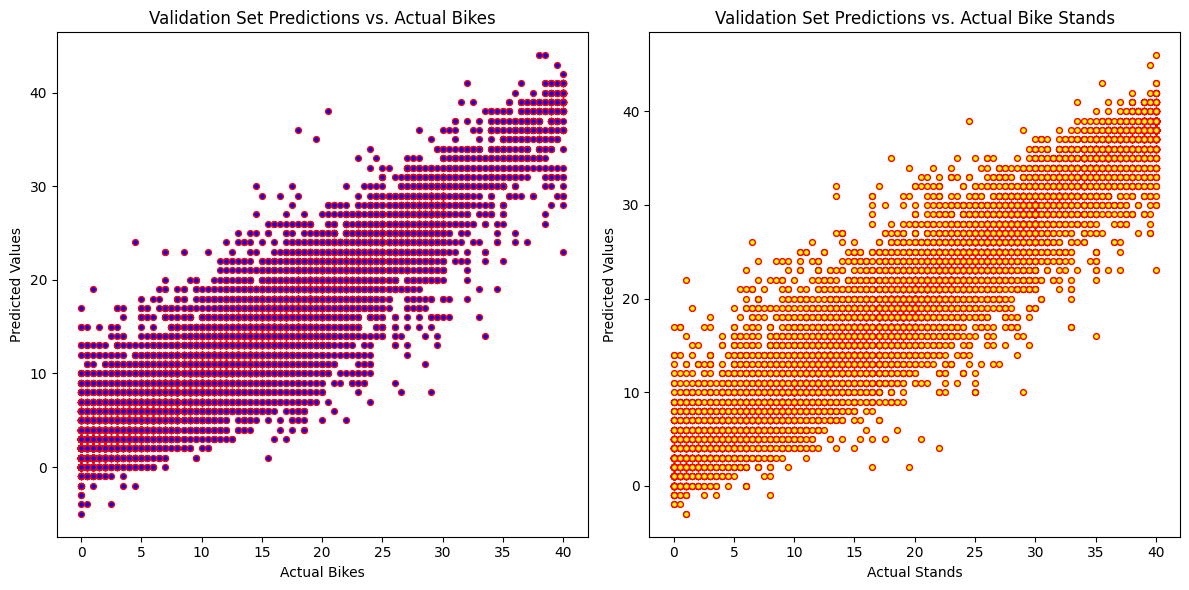

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(y_test['bikes'], predictions_inv[:, 1], marker='.', color='blue' ,edgecolors='red', s=70)
axs[0].set_xlabel('Actual Bikes')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Validation Set Predictions vs. Actual Bikes')

axs[1].scatter(y_test['bike_stands'], predictions_inv[:, 0], marker='.', color='yellow' ,edgecolors='red', s=70)
axs[1].set_xlabel('Actual Stands')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Validation Set Predictions vs. Actual Bike Stands')

plt.tight_layout()
plt.show()

#

In [49]:
from datetime import datetime
import requests
import json
import os
from dotenv import load_dotenv

load_dotenv()

link = 'https://api.jcdecaux.com/vls/v1/stations'
api = os.getenv('db_api')
contract = 'Dublin'

response = requests.get(link, 
                        params={"apiKey": api, 
                                "contract": contract})
response.raise_for_status()
now = datetime.now()
data = response.text
data = json.loads(data)
data = pd.json_normalize(data)

In [50]:
data[data['number']==21]

,number,contract_name,name,address,banking,bonus,bike_stands,available_bike_stands,available_bikes,status,last_update,position.lat,position.lng
112,21,dublin,LEINSTER STREET SOUTH,Leinster Street South,False,False,30,10,20,OPEN,1710762624000,53.34218,-6.254485


In [51]:
from tabulate import tabulate
filtered_data = data[data['number'] == 100].copy()
filtered_data['time_stamp'] = pd.to_datetime(filtered_data['last_update'], unit='ms')
new_data = pd.DataFrame()

new_data['time_stamp'] = filtered_data['time_stamp'].dt.round('H')
new_data['id'] = filtered_data['number']
new_data['hour'] = new_data['time_stamp'].dt.hour
new_data['date_only'] = new_data['time_stamp'].dt.day
new_data['day_of_week'] = new_data['time_stamp'].dt.dayofweek
new_data['month_number'] = new_data['time_stamp'].dt.month
new_data = new_data.drop('time_stamp', axis=1)
new_data_processed = preprocessor.transform(new_data)

rf =  regressor_rf.predict(new_data)
xgb = regressor_xgb.predict(new_data)
knn = scalar1.inverse_transform(regressor_knn.predict(new_data_processed).reshape(-1, 1)).item()

fin = round_nearest((xgb + knn)/2)

actual_bikes = filtered_data['available_bikes'].values[0]
predictions_bikes = [
    actual_bikes,
    rf,
    xgb,
    knn,
    np.round(fin)
]


rf =  regressor_rf2.predict(new_data)
xgb = regressor_xgb2.predict(new_data)
knn = scalar2.inverse_transform(regressor_knn2.predict(new_data_processed).reshape(-1, 1)).item()

fin = round_nearest((xgb + knn)/2)

actual_stands = filtered_data['available_bike_stands'].values[0]
predictions_stands = [
    actual_stands,
    rf,
    xgb,
    knn,
    fin
]

headers = ["Model", "Predicted Value"]

model_names_bikes = ["Actual", "RF", "XGB", "KNN", 'avg', 'rnn']
data_bikes = list(zip(model_names_bikes, predictions_bikes))

model_names_stands = ["Actual", "RF2", "XGB2", "KNN2", 'avg']
data_stands = list(zip(model_names_stands, predictions_stands))

print(f"Predicted Bikes Availability:")
print(tabulate(data_bikes, headers=headers))
print(f"\nPredicted Bikes Stands Availability:")
print(tabulate(data_stands, headers=headers))

Predicted Bikes Availability:
Model      Predicted Value
-------  -----------------
Actual            23
RF                 1.53
XGB                3.35792
KNN                1.98346
avg                3

Predicted Bikes Stands Availability:
Model      Predicted Value
-------  -----------------
Actual              2
RF2                23.42
XGB2               19.7594
KNN2               23.0165
avg                21


# KNN's results are consistent and better than average of all models so will choose KNN and its scalable for future data as well

In [52]:
# for bike, stand in zip(bikes_res, stands_res):
#     print(bike, stand)

In [53]:
import pickle
with open('../models/ava_time/bikes/KNearestNeighbors.pkl', 'rb') as model_file:
    model_data = pickle.load(model_file)

preprocessor = model_data['preprocessor']
scalar1 = model_data['scalar']
regressor_knn = model_data['model']

with open('../models/ava_time/bike_stands/KNearestNeighbors.pkl', 'rb') as model_file:
    model_data = pickle.load(model_file)

scalar2 = model_data['scalar']
regressor_knn2 = model_data['model']

## Forecast for next Week

In [54]:
from datetime import datetime, timedelta
current_date = datetime.now()
one_week_datetime_array = [(current_date + timedelta(hours=i)).strftime('%Y-%m-%d %H:%M:%S') for i in range(24 * 7)]
datetime_index = pd.to_datetime(one_week_datetime_array)

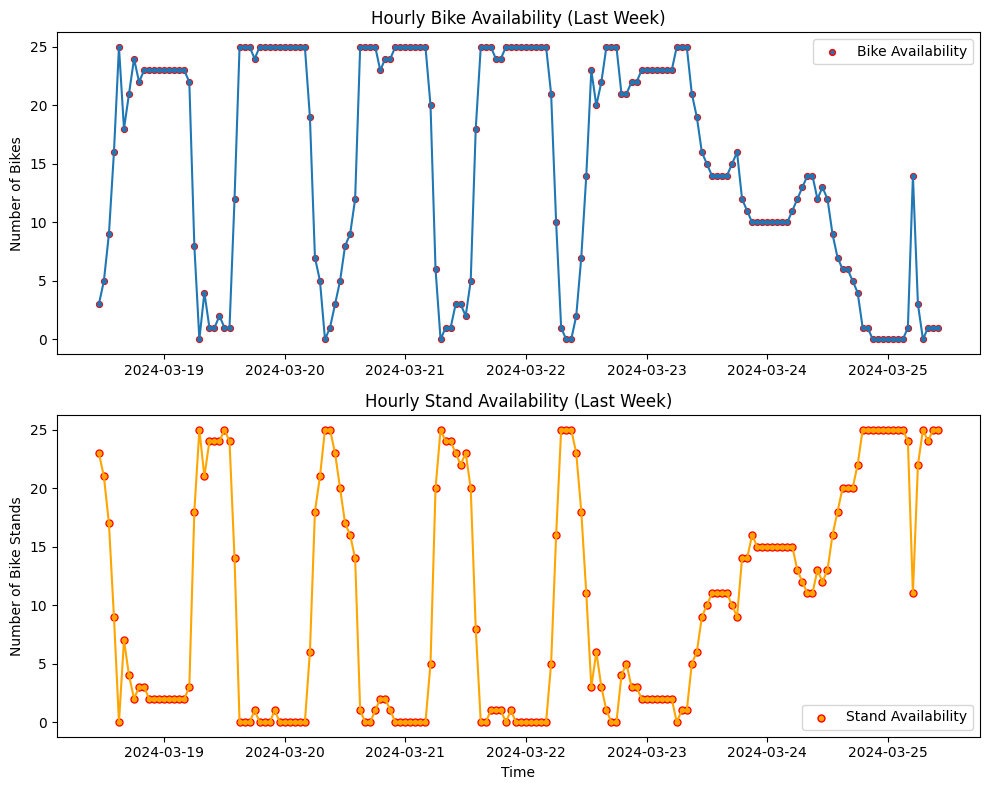

In [55]:
stands_res = []
bikes_res = []
for i in range(len(datetime_index)):
    filtered_data['time_stamp'] = datetime_index[i]
    new_data = pd.DataFrame()
    new_data['id'] = filtered_data['number']
    new_data['time_stamp'] = filtered_data['time_stamp'].dt.round('H')
    new_data['hour'] = new_data['time_stamp'].dt.hour
    new_data['date_only'] = new_data['time_stamp'].dt.day
    new_data['month_number'] = new_data['time_stamp'].dt.month
    new_data['day_of_week'] = new_data['time_stamp'].dt.dayofweek
    new_data = new_data.drop('time_stamp', axis=1)
    new_data_processed = preprocessor.transform(new_data)

    bike = round_nearest(scalar1.inverse_transform(regressor_knn.predict(new_data_processed).reshape(-1, 1)).item())
    stand = round_nearest(scalar2.inverse_transform(regressor_knn2.predict(new_data_processed).reshape(-1, 1)).item())
    bikes_res.append(bike)
    stands_res.append(stand)

data_plot = pd.DataFrame()
data_plot["time_stamp"] = datetime_index
data_plot["bikes"] = bikes_res
data_plot["stands"] = stands_res

data_plot['time_stamp'] = pd.to_datetime(data_plot['time_stamp'])
data_plot.set_index('time_stamp', inplace=True)

last_week_data = data_plot.loc[data_plot.index >= (data_plot.index.max() - pd.Timedelta(days=7))]
hourly_data_last_week = last_week_data.resample('H').mean()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].plot(hourly_data_last_week.index, hourly_data_last_week['bikes'], marker='.')
axes[0].scatter(hourly_data_last_week.index, hourly_data_last_week['bikes'], edgecolors='red', s=70, label='Bike Availability', marker='.')
axes[0].set_title('Hourly Bike Availability (Last Week)')
axes[0].set_ylabel('Number of Bikes')
axes[0].legend()

axes[1].plot(hourly_data_last_week.index, hourly_data_last_week['stands'], marker='.', color='orange')
axes[1].scatter(hourly_data_last_week.index, hourly_data_last_week['stands'], color='orange', edgecolors='red', s=100, label='Stand Availability', marker='.')
axes[1].set_title('Hourly Stand Availability (Last Week)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Number of Bike Stands')
axes[1].legend()

plt.tight_layout()
plt.show()